In [130]:
import os
import sys
import glob 
import random
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
from statsmodels import robust

import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import IPython.display as ipd 

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

In [131]:
#initializing all the file path to a variable
AUDIO_PATH = r'C:\Users\harsh\Desktop\esc50 and YBSS-200'
CSV_PATH = r'C:\Users\harsh\Desktop\noise_classifiaction\excel sheets\esc50andYBSS200.csv'
CSV_PATH1 = r'C:\Users\harsh\Desktop\noise_classifiaction\excel sheets\first5keywords.csv'
CSV_PATH2 = r'C:\Users\harsh\Desktop\noise_classifiaction\excel sheets\first10keywords.csv'
CSV_PATH3 = r'C:\Users\harsh\Desktop\noise_classifiaction\excel sheets\first15keywords.csv'
CSV_PATH4 = r'C:\Users\harsh\Desktop\noise_classifiaction\excel sheets\YBSS_dataset.csv'
CSV_PATH5 = r'C:\Users\harsh\Desktop\noise_classifiaction\excel sheets\esc50new.csv'

## Part 1: Primary data analysis


In [132]:
df = pd.read_csv(CSV_PATH3)
print("shape of df: ", df.shape)
df.head()

#checking the content of the file

shape of df:  (600, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
3,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A
4,1-103999-A-30.wav,1,30,door_wood_knock,False,103999,A


In [133]:
df=df.drop(['fold','esc10','src_file','take'], axis=1)
print("shape of df: ", df.shape)
print(df)
#filtering the table and removing the unwanted data

shape of df:  (600, 3)
              filename  target         category
0     1-100032-A-0.wav       0              dog
1    1-100038-A-14.wav      14   chirping_birds
2    1-101336-A-30.wav      30  door_wood_knock
3    1-103995-A-30.wav      30  door_wood_knock
4    1-103999-A-30.wav      30  door_wood_knock
..                 ...     ...              ...
595  5-263490-A-25.wav      25        footsteps
596  5-263491-A-25.wav      25        footsteps
597  5-263501-A-25.wav      25        footsteps
598   5-51149-A-25.wav      25        footsteps
599     5-9032-A-0.wav       0              dog

[600 rows x 3 columns]


In [134]:
#check NAS
df.isna().sum()
#checking for any file empty 

filename    0
target      0
category    0
dtype: int64

In [135]:
NUM_CLASSES = len(df['category'].unique())
len(df['category'].unique())

#printing all the unique catagories 

15

In [136]:
df['target'].value_counts()

#checking if all classes have 40 audio files

0     40
14    40
30    40
47    40
31    40
32    40
16    40
25    40
43    40
29    40
7     40
24    40
21    40
5     40
33    40
Name: target, dtype: int64

In [137]:
len(df) == len(df['filename'].unique())

True

In [138]:
classes = df['category'].unique()
classes

array(['dog', 'chirping_birds', 'door_wood_knock', 'airplane',
       'mouse_click', 'keyboard_typing', 'wind', 'footsteps', 'car_horn',
       'drinking_sipping', 'insects', 'coughing', 'sneezing', 'cat',
       'door_wood_creaks'], dtype=object)

## Part 2: Analysis of audio tracks

In [139]:
## an instance of each class
unique_class_df = df.drop_duplicates(subset=['target'])
unique_class_df.head()
classes = df['category'].unique()
class_dict = {i:x for x,i in enumerate(classes)}
df['target'] = df['category'].map(class_dict)
df


,filename,target,category
0,1-100032-A-0.wav,0,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-101336-A-30.wav,2,door_wood_knock
3,1-103995-A-30.wav,2,door_wood_knock
4,1-103999-A-30.wav,2,door_wood_knock
...,...,...,...
595,5-263490-A-25.wav,7,footsteps
596,5-263491-A-25.wav,7,footsteps
597,5-263501-A-25.wav,7,footsteps
598,5-51149-A-25.wav,7,footsteps


In [140]:
X = []
y = []
for data in tqdm(df.iterrows(),  desc='Progress'):
    sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
    #taking 3 windows from 0-2 , 2-4 , 3-5 seconds
    sig_ = sig[0 : 88200]
    if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
    sig_ = sig[88200 : 176400]
    if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
    sig_ = sig[132300 : 220500]
    if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])

Progress: 0it [00:00, ?it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.01184082 -0.10336304 -0.14141846 ...  0.03210449  0.01708984
  0.01116943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00784302  0.00158691 -0.0039978  ...  0.01745605 -0.04656982
 -0.08792114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.02581787 0.04159546 0.05267334 ... 0.06985474 0.04049683 0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00384521 -0.00390625 -0.00396729 ... -0.00717163 -0.00299072
 -0.00476074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progress: 14it [00:00, 40.49it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.01907349 -0.02053833 -0.02270508 ...  0.00323486  0.00253296
  0.00210571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00445557  0.00387573  0.00442505 ... -0.00634766 -0.00509644
 -0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.featur

Progress: 28it [00:00, 51.95it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.17254639 -0.23001099 -0.27349854 ...  0.22109985  0.22531128
  0.22909546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.23254395  0.23553467  0.23693848 ...  0.00299072 -0.00100708
 -0.00445557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.06243896 -0.05856323 -0.0552063  ... -0.02716064 -0.02694702
 -0.02642822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.featur

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.2088623  -0.19387817 -0.18078613 ... -0.00213623 -0.00238037
 -0.00228882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.00085449 0.00079346 0.00088501 ... 0.00308228 0.00286865 0.0027771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00296021 0.00305176 0.00311279 ... 0.0027771  0.00323486 0.00289917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00085449 -0.00152588 -0.00222778 ...  0.00030518  0.00021362
  0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.69055176 0.72494507 0.7583008  ... 0.01046753 0.01834106 0.02731323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.0369873  0.04614258 0.05377197 ... 0.3170166  0.3116455  0.3062439 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00091553 -0.00106812
 -0.0012207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.          0.00036621  0.00015259 ... -0.00253296 -0.00457764
 -0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.85025024 -0.7727356  -0.7151489  ... -0.6904907  -0.72314453
 -0.7437744 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 51

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-3.0517578e-05  2.1362305e-04  0.0000000e+00 ... -6.4086914e-04
 -4.5776367e-04 -3.9672852e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00057983 -0.00054932 -0.00042725 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00131226 -0.0015564  -0.00146484 ... -0.00714111 -0.00735474
 -0.00784302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00198364  0.00213623  0.00247192 ... -0.0067749  -0.00698853
 -0.0071106 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.00579834  0.0057373   0.00564575 ... -0.01513672 -0.01519775
 -0.01565552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.02679443 -0.02285767 -0.01712036 ...  0.00012207  0.00018311
  0.00021362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

Progress: 88it [00:02, 38.50it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00961304  0.0017395  -0.01586914 ...  0.10565186  0.28231812
  0.62228394] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.5942993  0.18997192 0.0138855  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\hars

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.01852417  0.02890015  0.03634644 ...  0.00073242  0.00253296
 -0.00296021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.02438354 -0.01992798 -0.01889038 ... -0.01733398 -0.00912476
 -0.00485229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progress: 99it [00:02, 39.50it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.01004028 0.01074219 0.01086426 ... 0.00463867 0.00384521 0.00286865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(

Progress: 110it [00:02, 43.52it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00350952  0.00488281  0.00506592 ... -0.04129028 -0.04348755
 -0.04464722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.04534912 -0.04702759 -0.04815674 ...  0.03482056  0.03601074
  0.03662109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.09231567 0.09225464 0.09069824 ... 0.06460571 0.06481934 0.06500244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-5.7983398e-04 -2.1362305e-04  2.1362305e-04 ... -6.1035156e-05
  2.1362305e-04 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-3.9672852e-04  1.5258789e-04  3.0517578e-05 ... -4.5776367e-04
 -2.1362305e-04 -2.1362305e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 3.0517578e-05 -1.2207031e-04  1.8310547e-04 ...  1.8310547e-04
 -1.2207031e-04  1.8310547e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  m

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.06036377 0.0647583  0.06710815 ... 0.06918335 0.0743103  0.07635498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.07852173  0.07571411  0.0710144  ... -0.08380127 -0.08978271
 -0.09359741] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.0118103   0.0111084   0.01077271 ... -0.03564453 -0.03723145
 -0.04217529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.01568604 0.01809692 0.02108765 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.0043335  -0.00448608 -0.00418091 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.00738525 0.0177002  0.0295105  ... 0.00021362 0.00021362 0.00012207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progres

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.02822876  0.02844238  0.0291748  ...  0.00146484  0.00027466
 -0.00189209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00860596 -0.00872803 -0.00961304 ...  0.00592041  0.00640869
  0.00482178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00427246 -0.00476074 -0.00393677 ... -0.00024414 -0.00024414
 -0.00024414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00247192 -0.00253296 -0.00268555 ...  0.00164795  0.00158691
  0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00152588 0.0015564  0.00140381 ... 0.36950684 0.38882446 0.40924072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00201416 -0.00201416 -0.00210571 ... -0.00411987 -0.0043335
 -0.0045166 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_m

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.00311279 0.00317383 0.00302124 ... 0.00241089 0.00265503 0.00253296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00238037 0.00271606 0.00274658 ... 0.00030518 0.00039673 0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00106812 -0.00112915 -0.00109863 ...  0.00115967  0.0012207
  0.00125122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.02905273  0.05047607  0.07092285 ... -0.10211182 -0.05944824
 -0.0196228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.35064697  0.29370117  0.22329712 ... -0.00164795 -0.0105896
 -0.02627563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.0112915  -0.01208496 -0.01565552 ... -0.02523804 -0.02301025
 -0.02090454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 5

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00805664 -0.00415039 -0.00021362 ... -0.01037598 -0.01025391
 -0.01834106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.18640137 -0.17596436 -0.16668701 ...  0.10568237  0.10238647
  0.09933472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.09576416 0.09390259 0.09463501 ... 0.08132935 0.08215332 0.08184814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.05224609 0.05252075 0.05310059 ... 0.12747192 0.12362671 0.11886597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.11407471 0.10852051 0.10275269 ... 0.07125854 0.06555176 0.05938721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.09671021 0.09295654 0.0892334  ... 0.01870728 0.02038574 0.0222168 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Us

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[3.0517578e-05 3.0517578e-05 3.0517578e-05 ... 4.5776367e-04 4.5776367e-04
 4.5776367e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.03152466  0.03109741  0.03100586 ... -0.06234741 -0.06188965
 -0.06112671] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.06130981 -0.05905151 -0.05688477 ...  0.0098877   0.0005188
  0.00408936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00354004  0.00311279  0.00750732 ...  0.00497437  0.00494385
  0.00506592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00830078 -0.00531006 -0.01690674 ... -0.0078125  -0.02749634
 -0.04678345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -1.8310547e-04 ...  7.3699951e-02
  9.3292236e-02  1.1529541e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr

Progress: 238it [00:05, 43.63it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00091553  0.00204468  0.00256348 ...  0.00012207  0.00192261
 -0.00036621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-9.1552734e-05  1.8310547e-04 -6.4086914e-04 ...  9.1552734e-05
  5.1879883e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-3.0517578e-05 -1.2207031e-04  7.0190430e-04 ...  1.8310547e-04
 -2.7465820e-04 -5.4931641e-04] as keyword args. From version 0.10 passing these as positional arguments will result

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.02294922  0.02648926  0.0161438  ... -0.00656128 -0.00689697
 -0.0072937 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.00927734 0.01498413 0.02593994 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00073242  0.0017395   0.00085449 ...  0.00073242 -0.00073242
 -0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00909424  0.00549316  0.0055542  ... -0.00878906 -0.00839233
 -0.00396729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00262451 -0.00167847  0.00244141 ...  0.03411865  0.0329895
  0.03411865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00604248 -0.01168823 -0.00619507 ... -0.05871582 -0.05947876
 -0.05490112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 5

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00100708 0.00115967 0.00170898 ... 0.00622559 0.00445557 0.00402832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00909424 -0.00836182 -0.00628662 ...  0.01843262  0.01480103
  0.00708008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.09741211  0.09542847  0.09197998 ...  0.00091553 -0.0020752
 -0.00656128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_m

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.015625   -0.01296997 -0.01144409 ...  0.01132202  0.01330566
  0.01687622] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.01831055 0.02120972 0.02182007 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.06140137  0.05300903  0.0630188  ... -0.08477783 -0.09729004
 -0.12322998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.42190552  0.486969    0.30377197 ... -0.00167847 -0.00442505
 -0.0050354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00823975 -0.00836182 -0.00863647 ...  0.00222778  0.00134277
  0.00073242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00161743 -0.0020752  -0.00268555 ...  0.00021362  0.00076294
  0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00222778 -0.00222778 -0.00210571 ...  0.02157593  0.01922607
  0.0196228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.01724243 0.01333618 0.01062012 ... 0.00738525 0.00820923 0.00866699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.0552063  -0.0546875  -0.05102539 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00091553 -0.00042725 -0.0010376  ...  0.01629639  0.01690674
  0.01864624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.01150513 -0.01046753 -0.01119995 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.0055542  -0.00588989 -0.00637817 ... -0.00112915 -0.00286865
 -0.00292969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_m

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00289917 -0.00772095 -0.00292969 ...  0.01544189  0.01959229
  0.02233887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00134277 -0.00115967 -0.00054932 ... -0.00079346 -0.00067139
 -0.00088501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-3.9672852e-04 -3.3569336e-04 -8.2397461e-04 ... -6.1035156e-05
 -9.1552734e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , s

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00097656  0.00091553  0.00088501 ... -0.01095581 -0.01092529
 -0.01092529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00061035 -0.0005188  -0.00048828 ...  0.00042725  0.00045776
  0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 3.05175781e-05  3.05175781e-05  3.05175781e-05 ... -1.09710693e-01
 -1.19018555e-01 -1.27166748e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(si

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.10702515  0.10797119  0.10824585 ... -0.09344482 -0.10266113
 -0.11584473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.12658691 -0.13598633 -0.14642334 ... -0.67926025 -0.67492676
 -0.6682739 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.13586426 -0.11428833 -0.08905029 ...  0.37747192  0.3994751
  0.42022705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 5

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.5083618  0.32302856 0.12225342 ... 0.00717163 0.006073   0.0067749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.01452637 -0.01013184 -0.00787354 ...  0.00683594  0.00567627
  0.00567627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.00073242 0.00369263 0.00030518 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00036621  0.00079346  0.00021362 ... -0.05462646 -0.04315186
 -0.05722046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-7.4554443e-02 -7.0037842e-02 -6.5429688e-02 ...  3.0517578e-05
  6.1035156e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.04177856 0.02584839 0.02438354 ... 0.17333984 0.12442017 0.0652771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.02865601 -0.03503418 -0.04107666 ...  0.00302124  0.00201416
  0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.12124634 -0.13024902 -0.13793945 ...  0.19119263  0.16992188
  0.14764404] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.04598999 -0.04846191 -0.05099487 ... -0.03994751 -0.04180908
 -0.04180908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00924683 -0.00927734 -0.00918579 ...  0.0763855   0.07876587
  0.081604  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  0.0000000e+00 ... -5.7983398e-04
 -6.1035156e-04 -5.1879883e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 9.1552734e-05  3.6621094e-04  3.3569336e-04 ... -3.1219482e-02
  1.9683838e-02  5.5297852e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.fea

Progress: 398it [00:09, 40.77it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.7366028   0.71850586  0.6838989  ... -0.09539795 -0.13034058
 -0.16375732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.1972351  -0.22610474 -0.2401123  ... -0.02450562 -0.01940918
 -0.01083374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.1713562   0.15982056  0.14498901 ... -0.25146484 -0.2520752
 -0.25106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.featur

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-3.3569336e-04 -4.5776367e-04 -3.3569336e-04 ...  1.8310547e-04
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progress: 408it [00:09, 39.92it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00100708  0.00091553 -0.00186157 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-4.2724609e-04 -6.1035156e-05 -6.1035156e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an er

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00106812 -0.00109863 -0.00091553 ...  0.00073242  0.00100708
  0.00067139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00149536 -0.00109863 -0.00094604 ... -0.00106812 -0.00219727
 -0.00354004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progress: 421it [00:09, 45.75it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00015259 -0.00033569 -0.00021362 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(

Progress: 432it [00:09, 48.84it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.00296021 0.00378418 0.00384521 ... 0.00317383 0.00341797 0.00369263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00393677  0.00408936  0.00411987 ... -0.03610229 -0.04058838
 -0.04483032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.00180054 0.00115967 0.00064087 ... 0.00708008 0.00820923 0.00601196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ ,

Progress: 442it [00:10, 45.20it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00054932 -0.00131226 -0.00109863 ... -0.00048828 -0.0005188
 -0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00039673 -0.00048828 -0.00054932 ... -0.00024414 -0.00027466
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.00311279  0.00473022  0.00473022 ... -0.00012207 -0.00021362
 -0.00015259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.featur

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.03042603 -0.00613403  0.02087402 ... -0.0010376  -0.0005188
  0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00018311 -0.00152588  0.00100708 ... -0.00421143 -0.00540161
 -0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.00354004 -0.00299072  0.00021362 ... -0.00137329 -0.00186157
 -0.00189209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 5

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.00027466 0.00027466 0.00021362 ... 0.00402832 0.00512695 0.00592041] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-9.1552734e-05 -6.1035156e-05  0.0000000e+00 ...  2.7465820e-04
  1.5258789e-04 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-1.2207031e-04 -2.4414062e-04 -3.0517578e-05 ... -2.7465820e-04
 -3.0517578e-04 -2.7465820e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mf

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 1.46484375e-02  1.43127441e-02  1.40380859e-02 ... -1.22070312e-04
 -9.15527344e-05 -3.05175781e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 9.1552734e-05  0.0000000e+00  0.0000000e+00 ... -9.1552734e-05
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progress: 472it [00:10, 44.61it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.11303711 -0.09631348 -0.02526855 ...  0.06130981  0.02780151
 -0.0269165 ] as keyword args. From version 0.10 passing these as positional arguments will 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.01068115  0.00762939  0.0039978  ... -0.01980591 -0.01556396
 -0.0213623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.08773804 -0.08917236 -0.08947754 ... -0.43634033 -0.43963623
 -0.44058228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.11035156 0.11160278 0.11694336 ... 0.05474854 0.05032349 0.04800415] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-9.1552734e-05 -1.2207031e-04 -1.5258789e-04 ... -8.8195801e-03
 -7.8125000e-03 -7.0190430e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00140381 -0.0020752  -0.00033569 ...  0.00106812  0.0020752
  0.00265503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00454712 0.00436401 0.00036621 ... 0.06964111 0.07302856 0.05923462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[2.6794434e-02 2.5970459e-02 2.4932861e-02 ... 6.1035156e-05 6.1035156e-05
 6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00012207 0.00015259 0.00018311 ... 0.00018311 0.00015259 0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.00341797  0.00463867  0.00567627 ... -0.00085449 -0.00082397
 -0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_leng

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.03005981 -0.09387207 -0.0696106  ... -0.0397644  -0.05093384
 -0.07122803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.07568359 -0.12417603 -0.16433716 ...  0.04772949  0.05401611
  0.04864502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.13598633  0.10586548  0.10662842 ... -0.09375    -0.09866333
 -0.0803833 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.00115967  0.0012207   0.00128174 ... -0.00158691 -0.00177002
 -0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.16485596  0.19012451  0.14816284 ...  0.25100708 -0.17056274
 -0.7197876 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-3.7997437e-01 -1.6906738e-01 -8.1390381e-02 ...  1.2207031e-04
  1.5258789e-04  2.4414062e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , s

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.00109863  0.00143433  0.00131226 ... -0.0112915  -0.01077271
 -0.01016235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.00991821 -0.01089478 -0.01193237 ...  0.00439453  0.00280762
  0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[-0.01791382 -0.01617432 -0.01486206 ... -0.00195312 -0.00247192
 -0.00195312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

Progress: 540it [00:12, 39.96it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 7.5683594e-03  9.7961426e-03  5.6762695e-03 ...  3.4179688e-03
 -6.1035156e-05  5.4931641e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.00112915 -0.00125122 -0.00134277 ...  0.00405884  0.00198364
  0.00238037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.01535034  0.01803589  0.01647949 ...  0.00268555 -0.00442505
 -0.00112915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfc

Progress: 551it [00:12, 44.15it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.00537109 -0.00601196 -0.00561523 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 3.0517578e-05 ... 6.5124512e-02 6.4910889e-02
 5.9661865e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[ 0.05401611  0.05062866  0.04766846 ... -0.01757812 -0.0196228
 -0.02032471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.fea

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.04858398 0.04718018 0.04672241 ... 0.07580566 0.09039307 0.08148193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[0.01034546 0.0105896  0.01037598 ... 0.00109863 0.00137329 0.00128174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.0730896   0.07528687  0.07772827 ... -0.06311035 -0.05822754
 -0.05276489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.04711914 -0.03512573 -0.00531006 ...  0.09732056  0.03765869
 -0.05239868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.10946655 -0.08825684 -0.00708008 ...  0.0105896  -0.06481934
 -0.10256958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.11053467  0.03717041 -0.06341553 ...  0.03390503 -0.04568481
 -0.09875488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[0.00201416 0.00201416 0.00180054 ... 0.00292969 0.00299072 0.00305176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -6.1035156e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
Progress: 586it [00:13, 44.19it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[-0.02297974 -0.02182007 -0.02069092 ... -0.01657104 -0.01391602
 -0.01055908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = li

Progress: 597it [00:13, 45.44it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:8: FutureWarning: Pass y=[ 0.01403809  0.01397705  0.01361084 ... -0.0218811  -0.02120972
 -0.02120972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:13: FutureWarning: Pass y=[-0.02255249 -0.02432251 -0.02514648 ...  0.01351929  0.01391602
  0.01257324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 512, n_mfcc=40)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\4223940870.py:18: FutureWarning: Pass y=[0.00234985 0.00241089 0.00204468 ... 0.00549316 0.00683594 0.00747681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\793207070.py:5: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(sig_,sr)


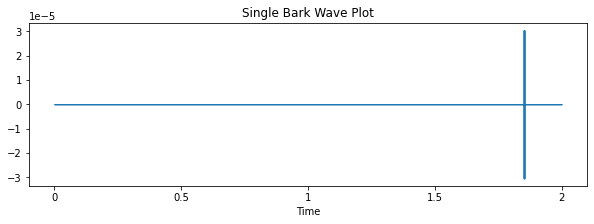

In [141]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10,3))
plt.title("Single Bark Wave Plot")
librosa.display.waveshow(sig_,sr)

In [142]:
X = np.array(X) 
y = np.array(y)

In [143]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (1468, 40, 173)
y Shape is:  (1468,)


In [144]:
y = tf.keras.utils.to_categorical(y , num_classes=15)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [146]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [147]:
INPUTSHAPE = (40,173,1)

In [148]:
y.shape

(1468, 15)

In [150]:
model =  models.Sequential([
    
  layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
  layers.MaxPooling2D(2, padding='same'),
  layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
  layers.MaxPooling2D(2, padding='same'),
  layers.Dropout(0.3),
  layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
  layers.MaxPooling2D(2, padding='same'),
  layers.Dropout(0.3),
  layers.GlobalAveragePooling2D(),
  
  layers.Dense(512 , activation = 'relu'),
  layers.Dense(15, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'Nadam', metrics = 'acc')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 38, 171, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 84, 128)       36992     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 9, 42, 128)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 9, 42, 128)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 40, 128)       

In [151]:
batch_size = 15
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train,
            validation_data=(X_test,y_test),
            epochs=25,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/25
79/79 [==============================] - 2s 11ms/step - loss: 2.2512 - acc: 0.2836 - val_loss: 1.8796 - val_acc: 0.3673
Epoch 2/25
79/79 [==============================] - 1s 7ms/step - loss: 1.5778 - acc: 0.4932 - val_loss: 1.5299 - val_acc: 0.4558
Epoch 3/25
79/79 [==============================] - 1s 7ms/step - loss: 1.2864 - acc: 0.5698 - val_loss: 1.2067 - val_acc: 0.6122
Epoch 4/25
79/79 [==============================] - 1s 7ms/step - loss: 1.0689 - acc: 0.6244 - val_loss: 1.5345 - val_acc: 0.5204
Epoch 5/25
79/79 [==============================] - 1s 7ms/step - loss: 0.8982 - acc: 0.6976 - val_loss: 1.1561 - val_acc: 0.6190
Epoch 6/25
79/79 [==============================] - 1s 7ms/step - loss: 0.7669 - acc: 0.7376 - val_loss: 1.8261 - val_acc: 0.4864
Epoch 7/25
79/79 [==============================] - 1s 7ms/step - loss: 0.7158 - acc: 0.7675 - val_loss: 1.6541 - val_acc: 0.6020
Epoch 8/25
79/79 [==============================] - 1s 8ms/step - loss: 0.6037 - acc: 0.7

Metrics





In [152]:
pred = model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


In [153]:
np.argmax(y_test,1)

array([13, 11,  8,  6,  9,  3,  4, 10, 11,  8,  6,  7, 10, 12,  7,  6,  0,
       13,  5,  5,  0,  4,  5,  0,  2,  7,  0, 10,  7,  2,  8,  4, 14,  8,
        8,  5,  0, 10,  3,  1, 14,  0,  6,  1,  2,  0,  1,  7, 11,  0,  4,
        1, 10,  1,  8, 11, 13,  2,  9,  4, 14,  1,  2, 14,  0, 11,  0, 13,
        6, 12,  5,  7,  1,  0,  5,  6,  9, 14,  7,  4, 10,  9,  1,  1, 13,
        1,  2,  3, 10,  8,  2,  7,  1,  1,  3,  0,  6,  9,  1, 10,  5,  6,
       10,  3,  1,  4,  2,  3,  0,  2,  3,  9, 12,  4,  8, 13,  0,  6, 14,
        7,  3,  1, 12,  1, 14,  4, 14,  0, 11, 11,  2, 13,  4, 13, 11, 13,
        4,  6,  5, 13,  9,  7,  0, 10, 10, 10, 13,  3,  1,  3,  1,  2, 14,
       10,  6, 12,  6, 12,  2,  5,  6,  7,  7,  0,  6,  7,  7, 14,  4,  0,
        5, 12,  1,  7,  6,  4,  3, 14, 10,  2, 13,  0, 10,  4,  3, 10,  1,
        2,  9,  8,  9,  8,  9,  5, 13, 13, 13, 14,  3,  1, 14,  2,  6, 11,
       11,  7, 12,  3,  2,  4,  0,  8,  3,  0,  1,  4,  5,  2,  1,  6,  1,
        1,  4,  5,  5, 10

In [154]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,1), np.argmax(pred,1), target_names=classes))
#number of records in the test set=support

                  precision    recall  f1-score   support

             dog       0.88      0.88      0.88        26
  chirping_birds       1.00      0.83      0.91        29
 door_wood_knock       0.80      0.94      0.86        17
        airplane       0.91      0.95      0.93        21
     mouse_click       0.92      0.60      0.73        20
 keyboard_typing       0.84      1.00      0.91        21
            wind       0.87      0.91      0.89        22
       footsteps       0.82      0.43      0.56        21
        car_horn       0.44      0.94      0.60        16
drinking_sipping       0.71      0.86      0.77        14
         insects       0.71      0.93      0.81        27
        coughing       1.00      0.43      0.60        14
        sneezing       0.75      1.00      0.86        12
             cat       0.87      0.72      0.79        18
door_wood_creaks       1.00      0.44      0.61        16

        accuracy                           0.80       294
       macro

### Сonfusion matrix

Using this matrix, you can understand in which classes


model is wrong. (i.e. which class gets confused with the other)

In [155]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,1), np.argmax(pred,1))

<AxesSubplot:>

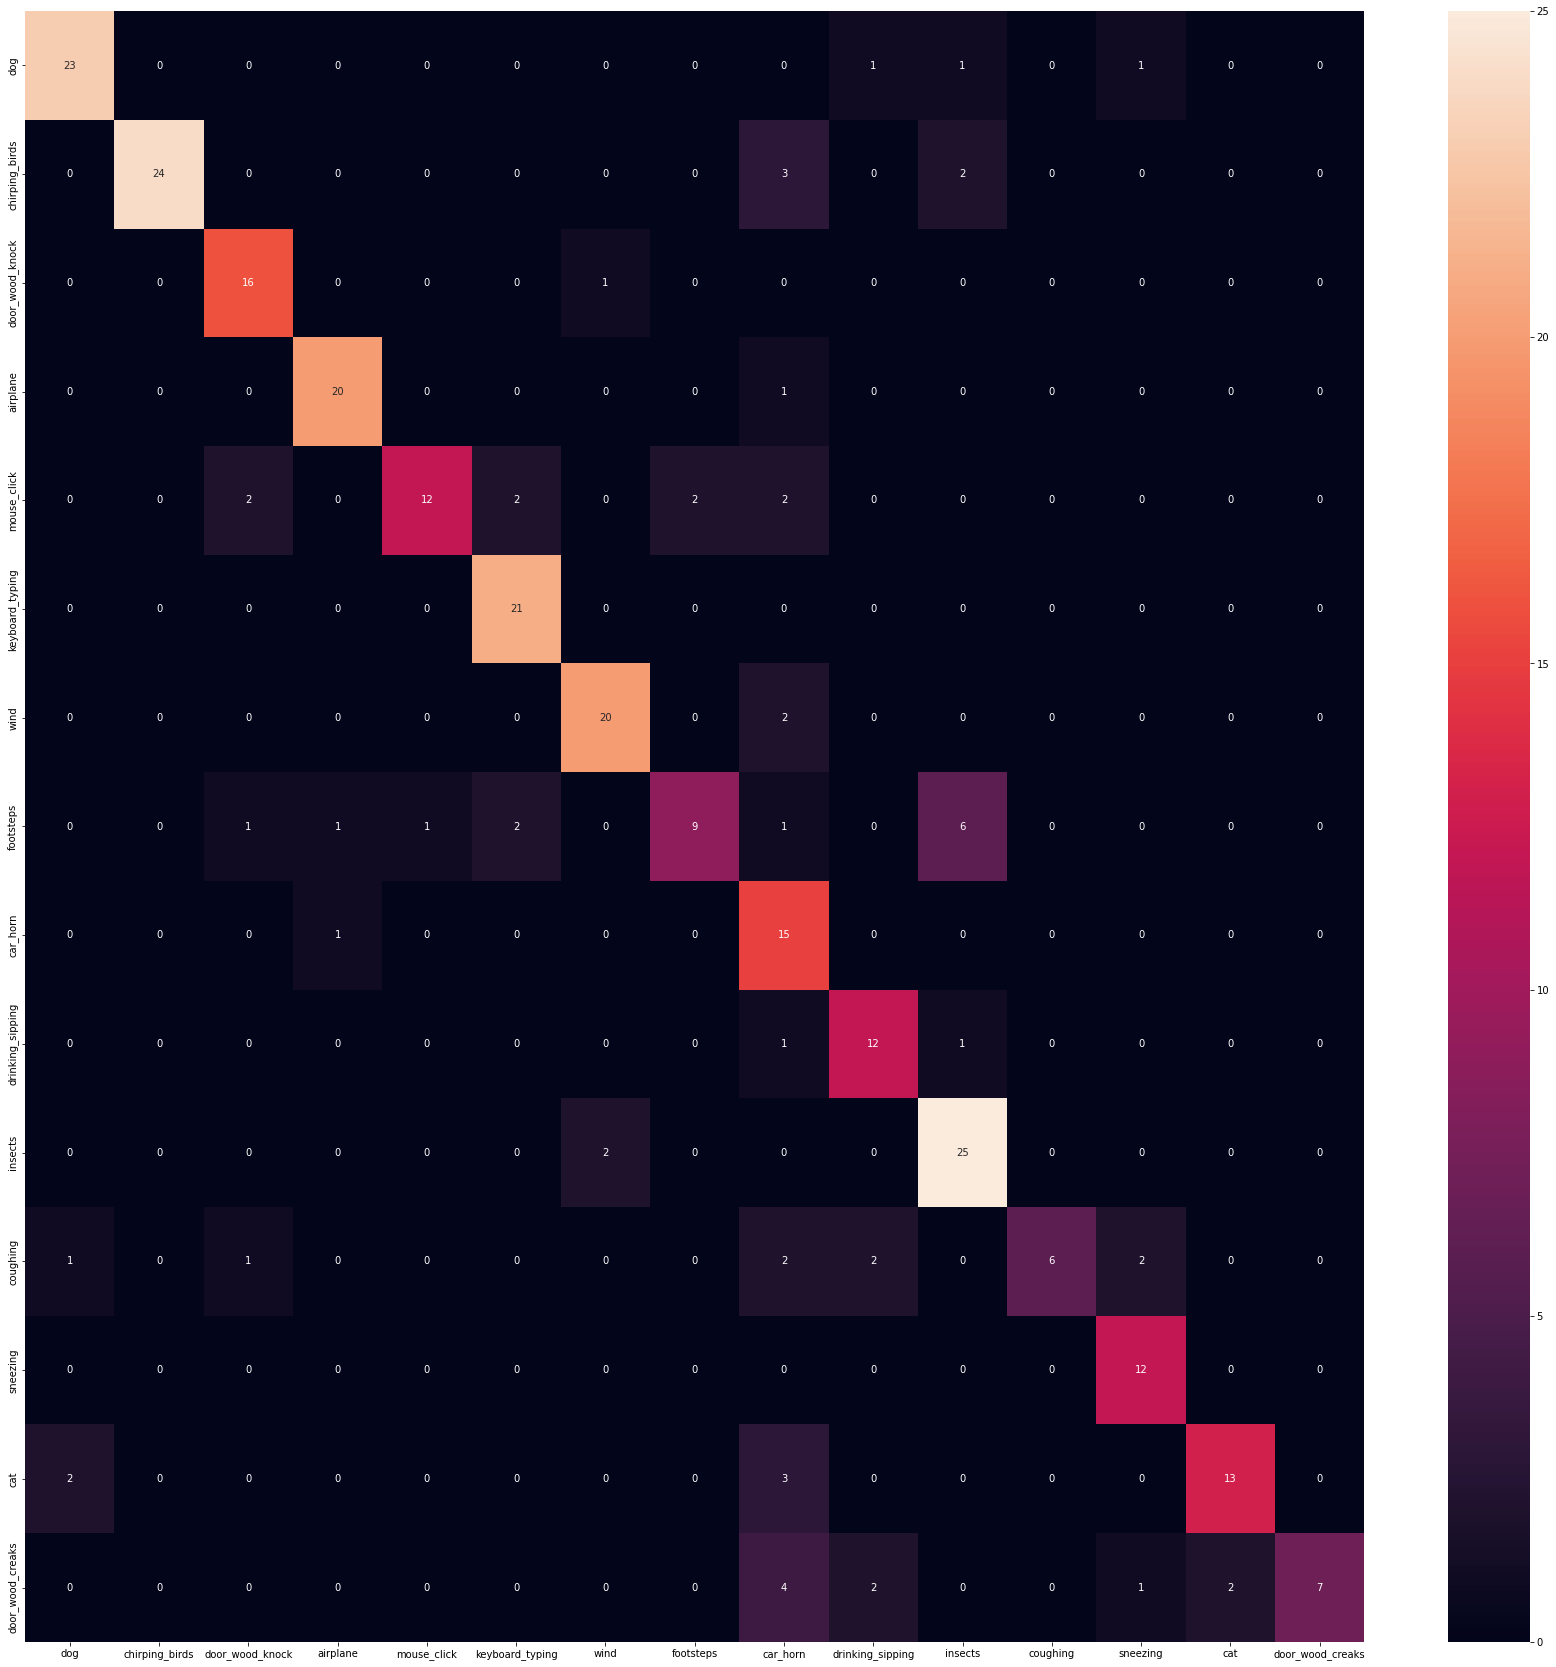

In [156]:
import seaborn as snNew
fig, ax = plt.subplots(figsize=(30,30))
snNew.heatmap(cm, annot=True, xticklabels= classes, yticklabels= classes)

In [170]:
x1 = []
y1 = []
for data in tqdm(df.iterrows(),  desc='Progress'):
        sig , sr = librosa.load(AUDIO_PATH + "\\" + data[1][0],sr = 44100)
        sig_ = sig[0 : 110250]
        mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
        x1.append(mfcc_)
        y1.append(data[1][1])
    

Progress: 0it [00:00, ?it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00183105 -0.00027466
 -0.00228882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.01184082 -0.10336304 -0.14141846 ... -0.10568237 -0.09866333
 -0.06314087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00012207 0.00018311 0.00012207 ... 0.01199341 0.01348877 0.01437378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = libr

Progress: 24it [00:00, 118.22it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00021362 0.00036621 0.00033569 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.03076172 0.03182983 0.03289795 ... 0.03222656 0.03009033 0.02734375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.07180786 -0.05603027 -0.02529907 ...  0.09817505  0.12576294
  0.0736084 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = libro

Progress: 48it [00:00, 115.16it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.0022583  -0.00222778 -0.00213623 ... -0.02874756 -0.02911377
 -0.02648926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00708008  0.00778198  0.02124023 ...  0.00082397  0.00079346
  0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.69055176  0.72494507  0.7583008  ... -0.13369751 -0.13238525
 -0.12792969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
 

Progress: 72it [00:00, 112.96it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.01580811  0.01577759  0.01568604 ... -0.03237915 -0.04559326
 -0.05050659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00167847 -0.00561523 -0.00836182 ...  0.00079346  0.00073242
  0.00073242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.03204346 -0.037323   -0.04345703 ...  0.02093506  0.03109741
  0.03240967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
 

Progress: 97it [00:00, 115.48it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.11520386  0.1486206   0.06900024 ... -0.10806274 -0.09960938
 -0.08157349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.04360962 0.03591919 0.03100586 ... 0.04141235 0.04888916 0.04562378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.01004028  0.01074219  0.01086426 ... -0.00439453 -0.00457764
 -0.00558472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ 

Progress: 122it [00:01, 117.30it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 2.1362305e-04  2.7465820e-04 -9.1552734e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00311279 -0.01034546 -0.01193237 ...  0.         -0.00079346
 -0.00079346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.01403809  0.01208496  0.01043701 ... -0.00396729 -0.00357056
 -0.00274658] as keyword args. From version 0.10 passing these as positional arguments will r

Progress: 146it [00:01, 116.76it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00152588 -0.00015259 -0.00021362 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05  3.0517578e-05 ...  6.1035156e-04
 -4.5776367e-04 -1.7089844e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.00680542  0.00793457  0.01092529 ... -0.05123901 -0.05105591
 -0.05221558] as keyword args. From version 0.10 passing these as positional arguments will result in

Progress: 170it [00:01, 116.59it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.07565308 -0.0446167   0.00177002 ... -0.00991821  0.00216675
  0.02114868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00036621 -0.00057983 -0.0005188  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.0000000e+00 1.5258789e-04 3.0517578e-05 ... 1.2512207e-03 1.2207031e-03
 1.0986328e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an er

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.01409912 -0.01629639 -0.0151062  ... -0.00286865  0.02157593
  0.04327393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.18640137 -0.17596436 -0.16668701 ... -0.252594   -0.25097656
 -0.24438477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.06640625 -0.0161438   0.03009033 ... -0.01803589 -0.0196228
 -0.01586914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.01339722 -0.0133667  -0.01303101 ... -0.02651978 -0.02276611
 -0.02493286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-5.0915527e-01 -5.8374023e-01 -5.2743530e-01 ...  3.0517578e-05
 -8.5449219e-04 -1.6784668e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.0000000e+00 -1.5258789e-04 -3.0517578e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00073242  0.0017395   0.00085449 ... -0.03439331 -0.02075195
 -0.01000977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.02386475  0.03643799  0.04376221 ... -0.02267456 -0.0289917
 -0.03335571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.01168823 0.01040649 0.0071106  ... 0.0753479  0.07104492 0.06652832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.02545166  0.02557373  0.02642822 ... -0.01928711 -0.01748657
 -0.0166626 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.1434021  -0.14382935 -0.14224243 ... -0.07751465 -0.08929443
 -0.09906006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.16491699 -0.15499878 -0.14871216 ...  0.19937134  0.19638062
  0.19647217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00915527 0.01016235 0.01101685 ... 0.0039978  0.00366211 0.00369263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00222778 -0.00222778 -0.00210571 ...  0.03530884  0.02972412
  0.02212524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00015259 0.00045776 0.00064087 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_l

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.04763794 -0.08111572 -0.06085205 ...  0.01586914  0.01678467
  0.00860596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00738525 -0.00595093 -0.00430298 ...  0.05239868  0.05957031
  0.04644775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[9.1552734e-05 9.1552734e-05 9.1552734e-05 ... 1.4654541e-01 1.0104370e-01
 5.5877686e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.featu

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-5.7983398e-04 -5.7983398e-04 -4.2724609e-04 ... -6.1035156e-05
  3.0517578e-03  5.2490234e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.10702515  0.10797119  0.10824585 ... -0.24777222 -0.24801636
 -0.25115967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 349it [00:03, 113.82it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.1076355   0.10470581  0.10195923 ... -0.04873657 -0.05743408
 -0.06747437] as keyword args. From version 0.10 passing these as positional arguments will r

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.02914429  0.02209473  0.01150513 ... -0.03170776  0.03085327
  0.1078186 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.01223755 -0.01184082 -0.01147461 ...  0.00576782  0.00601196
  0.00598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 373it [00:03, 114.05it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.05667114 -0.03988647 -0.05477905 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.12478638 0.10644531 0.08612061 ... 0.08145142 0.08642578 0.09118652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.05932617  0.03955078  0.02807617 ... -0.15219116 -0.04464722
  0.03903198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 398it [00:03, 114.41it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.7366028  0.71850586 0.6838989  ... 0.06869507 0.10055542 0.11334229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = libr

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00015259 -0.00033569 -0.00021362 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 3.0517578e-05  0.0000000e+00  0.0000000e+00 ... -9.1552734e-05
 -6.1035156e-05 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 423it [00:03, 115.05it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.00524902  0.00305176  0.00039673 ... -0.00149536 -0.00311279
 -0.0039978 ] as keyword args. From version 0.10 passing these as positional arguments will result in

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.00177002  0.00152588  0.00180054 ... -0.00033569 -0.00024414
 -0.00027466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00030518 -0.00033569  0.00036621 ... -0.00164795 -0.00161743
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 447it [00:03, 116.73it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00476074 -0.00650024 -0.00888062 ...  0.02148438  0.0206604
  0.01300049] as keyword args. From version 0.10 passing these as positional arguments will result in an error
 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.00195312  0.00332642  0.00311279 ... -0.01037598 -0.01101685
 -0.00939941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.07138062 0.07363892 0.07693481 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 471it [00:04, 116.89it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00 -9.1552734e-05 ...  0.0000000e+00
  0.0000000e+00  9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result i

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.13833618 -0.12414551 -0.08914185 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 495it [00:04, 116.47it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.0000000e+00 -9.1552734e-05  0.0000000e+00 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 1.3122559e-03  3.0822754e-03  4.7912598e-03 ... -3.0517578e-05
 -3.0517578e-05 -1.5258789e-04] as keyword args. From version 0.10 passing these as positional argume

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00064087 0.00073242 0.00067139 ... 0.00094604 0.00115967 0.00109863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 519it [00:04, 115.91it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00067139 0.00109863 0.00125122 ... 0.0088501  0.00897217 0.00805664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.00219727 0.0022583  0.00231934 ... 0.00097656 0.00091553 0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.fea

Progress: 543it [00:04, 113.42it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.03067017  0.02563477  0.02182007 ... -0.07516479 -0.07476807
 -0.07504272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.07104492  0.08206177  0.09124756 ... -0.13238525 -0.13897705
 -0.14413452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[0.01055908 0.01571655 0.02133179 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.00567627 -0.00289917  0.00192261 ...  0.01229858  0.01226807
  0.01196289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[ 0.00268555  0.00509644  0.0027771  ... -0.00534058 -0.00241089
  0.00265503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.0017395   0.00030518  0.00140381 ...  0.00067139 -0.003479
 -0.00650024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ ,

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-0.0887146  -0.07354736 -0.06958008 ...  0.06710815  0.0670166
  0.06716919] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3809647546.py:6: FutureWarning: Pass y=[-3.9672852e-04 -1.2207031e-04 -4.5776367e-04 ...  3.3569336e-04
  0.0000000e+00 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 640 , n_mfcc=40,dct_type=2)
Progress: 600it [00:05, 114.58it/s]


In [163]:
x1 = np.array(x1) 
y1 = np.array(y1)

In [164]:
print("X Shape is: ", x1.shape)
print("y Shape is: ", y1.shape)

X Shape is:  (600, 40, 173)
y Shape is:  (600,)


In [165]:
y1 = tf.keras.utils.to_categorical(y1 , num_classes=50)
x1 = x1.reshape(x1.shape[0], x1.shape[1], x1.shape[2], 1)

In [166]:
pred = model.predict(x1)

19/19 [==============================] - 0s 13ms/step


In [168]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y1,1), np.argmax(pred,1), target_names=classes))

                  precision    recall  f1-score   support

             dog       0.87      0.85      0.86        40
  chirping_birds       1.00      0.93      0.96        40
 door_wood_knock       0.82      0.93      0.87        40
        airplane       0.93      0.97      0.95        40
     mouse_click       0.97      0.72      0.83        40
 keyboard_typing       0.87      1.00      0.93        40
            wind       0.95      0.90      0.92        40
       footsteps       0.94      0.75      0.83        40
        car_horn       0.59      0.97      0.74        40
drinking_sipping       0.81      0.88      0.84        40
         insects       0.80      0.90      0.85        40
        coughing       1.00      0.57      0.73        40
        sneezing       0.75      0.97      0.85        40
             cat       0.89      0.85      0.87        40
door_wood_creaks       1.00      0.60      0.75        40

        accuracy                           0.85       600
       macro

In [174]:
test_path = r"C:\Users\harsh\Desktop\concatenated audio(15 noises)"

In [175]:
concat_test = []

In [176]:
for i in tqdm(file_names):
    sig , sr = librosa.load(test_path + "\\" + i,sr = 44100)
    sig_ = sig[0 : 441000]
    mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
    concat_test.append(mfcc_)
    #y1.append(data[1][1])
    

  0%|                                                                                          | 0/225 [00:00<?, ?it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.03588867 -0.03820801 -0.03875732 ...  0.04086304  0.05267334
  0.06201172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.03588867 -0.03820801 -0.03875732 ... -0.143219   -0.13134766
 -0.10070801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.03588867 -0.03820801 -0.03875732 ... -0.04620361 -0.06414795
 -0.0809021 ] as keyword 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00878906 -0.00982666 -0.01364136 ... -0.143219   -0.13134766
 -0.10070801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
 14%|███████████▍                                                                    | 32/225 [00:00<00:01, 103.10it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00878906 -0.00982666 -0.01364136 ... -0.04620361 -0.06414795
 -0.0809021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00878906 -0.00982666 -0.01364136 ...  0.06985474  0.04049683
  0.00274658] as keyword 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.5091553  -0.58374023 -0.5274353  ...  0.04086304  0.05267334
  0.06201172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.5091553  -0.58374023 -0.5274353  ... -0.143219   -0.13134766
 -0.10070801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.5091553  -0.58374023 -0.5274353  ... -0.04620361 -0.06414795
 -0.0809021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(si

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.0088501  -0.0112915  -0.00958252 ... -0.00653076 -0.00637817
 -0.00631714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.0088501  -0.0112915  -0.00958252 ...  0.00112915  0.00112915
  0.00119019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
 39%|██████████████████████████████▉                                                 | 87/225 [00:00<00:01, 101.44it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.0088501  -0.0112915  -0.00958252 ... -0.00604248 -0.00604248
 -0.00588989] as keyword 

 48%|██████████████████████████████████████▍                                         | 108/225 [00:01<00:01, 93.55it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00088501 -0.00082397 -0.00082397 ...  0.06985474  0.04049683
  0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00088501 -0.00082397 -0.00082397 ...  0.00466919  0.00454712
  0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00088501 -0.00082397 -0.00082397 ...  0.01443481  0.01705933
  0.01361084] as keyword 

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-5.6762695e-03 -2.8991699e-03  1.9226074e-03 ...  3.0517578e-05
  3.0517578e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00567627 -0.00289917  0.00192261 ... -0.0144043  -0.01153564
 -0.01473999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00076294  0.00033569 -0.00018311 ...  0.04086304  0.05267334
  0.06201172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = libro

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[ 0.00439453  0.0043335   0.00537109 ... -0.0284729  -0.02877808
 -0.02871704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
 70%|████████████████████████████████████████████████████████▏                       | 158/225 [00:01<00:00, 93.75it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[0.00439453 0.0043335  0.00537109 ... 0.03329468 0.03125    0.03063965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[ 0.00439453  0.0043335   0.00537109 ... -0.00653076 -0.00637817
 -0.00631714] as keyword args. F

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[ 0.00537109  0.0057373   0.0065918  ... -0.04620361 -0.06414795
 -0.0809021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[0.00537109 0.0057373  0.0065918  ... 0.06985474 0.04049683 0.00274658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[0.00537109 0.0057373  0.0065918  ... 0.00466919 0.00454712 0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop

C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00170898 -0.00137329 -0.00158691 ... -0.00604248 -0.00604248
 -0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-1.7089844e-03 -1.3732910e-03 -1.5869141e-03 ...  3.0517578e-05
  3.0517578e-05  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_ = librosa.feature.mfcc(sig_ , sr=sr,hop_length = 2550 , n_mfcc=40,dct_type=2)
 93%|██████████████████████████████████████████████████████████████████████████▎     | 209/225 [00:02<00:00, 94.63it/s]C:\Users\harsh\AppData\Local\Temp\ipykernel_10708\3581539939.py:4: FutureWarning: Pass y=[-0.00170898 -0.00137329 -0.00158691 ... -0.0144043  -0.01153564
 -0.014

In [177]:
len(sig)

441000

In [178]:
concat_test = np.array(concat_test)

In [179]:
concat_test = concat_test.reshape(concat_test.shape[0], concat_test.shape[1], concat_test.shape[2], 1)

In [180]:
concat_test.shape

(225, 40, 173, 1)

In [181]:
concat_test = np.array(concat_test)

In [182]:
prediction = model.predict(concat_test)

8/8 [==============================] - 0s 39ms/step


In [183]:
prediction_result=[]
for i in classes[np.argmax(prediction,1)]:
    prediction_result.append(i)

In [184]:
for i in classes[np.argmax(prediction,1)]:
    print(i)

airplane
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
footsteps
car_horn
footsteps
insects
airplane
airplane
footsteps
airplane
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
car_horn
dog
cat
dog
dog
car_horn
dog
cat
drinking_sipping
cat
cat
cat
cat
cat
car_horn
car_horn
cat
insects
drinking_sipping
footsteps
chirping_birds
drinking_sipping
sneezing
footsteps
insects
drinking_sipping
footsteps
keyboard_typing
insects
footsteps
car_horn
dog
drinking_sipping
drinking_sipping
drinking_sipping
door_wood_creaks
drinking_sipping
drinking_sipping
drinking_sipping
insects
drinking_sipping
drinking_sipping
drinking_sipping
drinking_sipping
car_horn
car_horn
dog
footsteps
drinking_sipping
drinking_sipping
door_wood_creaks
drinking_sipping
drinking_sipping
footsteps
insects
drinking_sipping
footsteps
footsteps
insects
car_horn
car_horn
car_horn
sneezing
drinking_sipping
door_wood_creaks
door_

In [185]:
prediction_result

['airplane',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'footsteps',
 'car_horn',
 'footsteps',
 'insects',
 'airplane',
 'airplane',
 'footsteps',
 'airplane',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'dog',
 'cat',
 'dog',
 'dog',
 'car_horn',
 'dog',
 'cat',
 'drinking_sipping',
 'cat',
 'cat',
 'cat',
 'cat',
 'cat',
 'car_horn',
 'car_horn',
 'cat',
 'insects',
 'drinking_sipping',
 'footsteps',
 'chirping_birds',
 'drinking_sipping',
 'sneezing',
 'footsteps',
 'insects',
 'drinking_sipping',
 'footsteps',
 'keyboard_typing',
 'insects',
 'footsteps',
 'car_horn',
 'dog',
 'drinking_sipping',
 'drinking_sipping',
 'drinking_sipping',
 'door_wood_creaks',
 'drinking_sipping',
 'drinking_sipping',
 'drinking_sipping',
 'insects',
 'drinking_sipping',
 'drinking_sipping

In [186]:
count = 0
for i in range(0,len(prediction_result)):
    w = file_names[i].split(".")[0]
    t = w.split("_and_")
    if prediction_result[i] in t:
        print(1)
        count = count+1
    else:
        print(0)

1
1
0
0
0
0
0
0
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
0
1
0
0
1
0
1
1
1
1
1
0
1
1
0
0
0
1
0
0
1
1
0
0
0
0
0
1
0
0
0
0
1
0
1
0
1
0
0
0
0
0
1
1
0
0
0
1
0
1
1
1
0
0
0
0
0
1
0
0
0
1
1
0
1
1
1
0
0
1
0
0
1
0
0
0
0
1
1
1
0
1
0
0
0
1
0
1
1
0
1
1
1
1
1
1
0
1
1
1
0
1
1
0
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
0
0
0
1
0
1
1
1
1
1
1
0
0
1
1
0
0
0
0
0
1
1
1
1
0
0
0
0
1
1
0
0
0
1
0
1
1
0
0
0
0
0
1
1
1
0
0
0
0
1
1
1
1
0
0
0
1


In [187]:
count

124

In [188]:
print(count/225)

0.5511111111111111
